# Los Angeles Crime Forecasting
#### Authors: David Bruce, Sidney Kung, Lhamu Tsering

<img src="visualizations/los-angeles-us-banner-dp-min.png">

## Overview

This summer (2020) saw a historic rise of demonstrations across the United States calling to 'Defund the Police.' Los Angeles Mayor, Eric Garcetti, reversed the trend of increasing police spending for the first time in years by reducing the Los Angeles Police Department (LAPD) budget by $150 million (NY Times). Using the most recent data on crime made available by the City of Los Angeles (data.lacity.org) from January 2010 - June 2019, we used univariate time series modeling to forecast reported crime in Los Angeles to determine recent crime trends in LA. Working with AR, MA, ARMA, and SARIMA models we determined the best fit with the lowest AIC score. Then evaluated our best model, a SARIMA model, using RMSE and AIC. The final model had an RMSE of 24.66.

## Business Problem

Los Angeles has the third largest police department in the country, with jurisdiction over almost 4 million people. The People’s Budget LA and other community movements have worked to push local government to search for alternative social service solutions to public safety. We set out to justify this divestment with time series predicting and forecasting. Through additional analysis of the data we identify which areas and populations in LA have been hit the hardest by crime in the last 9 years, so that budget resources can be reallocated to social services in those high-impact communities.

## Data Understanding

The data has 1,993,259 observations over 26 variables. Each row is a record of information on crime that was reported, where it occurred, when it occurred, what the crime was, and information on the victims of the crime. The crime data information is daily crime data collected from January of 2010 to end of June 2019. This dataset is the [LA Crime & Arrest Data](https://www.kaggle.com/cityofLA/los-angeles-crime-arrest-data) from Kaggle.  The data is transcribed from original crime reports that may contain inaccuracies.

In [89]:
# Importing Utility Functions
import numpy as np
import pandas as pd
import pickle
import itertools
import timeit

# Importing statmodels tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
 
# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Importing Graphing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import folium

# Importing Models
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


%load_ext autoreload
%autoreload 2
from src import modules

In [2]:
# Loading crime data csv file
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')

In [3]:
# Preview of crime data
df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,102005556,2010-01-25T00:00:00,2010-01-22T00:00:00,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"{'latitude': '34.0454', 'needs_recoding': Fals..."
1,101822289,2010-11-11T00:00:00,2010-11-10T00:00:00,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"{'latitude': '33.9572', 'needs_recoding': Fals..."
2,101105609,2010-01-28T00:00:00,2010-01-27T00:00:00,2230,11,Northeast,1125,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,YORK,AVENUE 51,"{'latitude': '34.1211', 'needs_recoding': Fals..."
3,101620051,2010-11-11T00:00:00,2010-11-07T00:00:00,1600,16,Foothill,1641,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,EL DORADO,TRUESDALE,"{'latitude': '34.241', 'needs_recoding': False..."
4,101910498,2010-04-07T00:00:00,2010-04-07T00:00:00,1600,19,Mission,1902,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,GLENOAKS,DRELL,"{'latitude': '34.3147', 'needs_recoding': Fals..."


In [4]:
df.shape

(1993259, 26)

## Data Cleaning
We will be loading the cleaned dataframe to work on further. However, **the detailed data cleaning process can be found in the data cleaning [notebook](./data_cleaning.ipynb)**

In [5]:
# Loading pickled cleaned df for ease of work in final notebook
clean_df = pd.read_pickle('data/pickled/cleaned_df.pkl')

## Data EDA

A detailed EDA can be found in the [EDA notebook](./EDA/EDA.ipynb).
Here, we will mainly explore data to show how our business questions were investigated.
We also look at the autocorrelation of the time series. To look at the linear relationship between numeric data we check the correlation factor. Similarly, in time series the linear relationship between a value and its previous observed value is checked on, by looking at the autocorrelation. 
We also explore decomposition of the time series data to examine seasonality and trends.

#### What areas in LA have the highest crime rate?

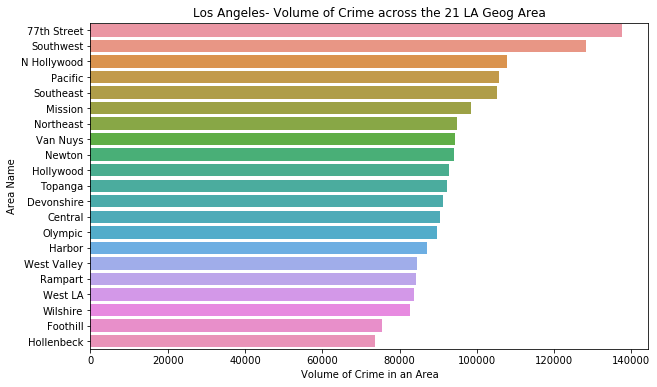

In [6]:
# Setting up figure
plt.figure(figsize=(10,6))

# Plotting categorial count plot for crime by area
sns.countplot(y='Area Name', data= clean_df, orient="h", 
              order=clean_df['Area Name'].value_counts().index)

# Setting x axis label and figure title
plt.xlabel('Volume of Crime in an Area')
plt.title('Los Angeles- Volume of Crime across the 21 LA Geog Area');

In [7]:
clean_df['Area Name'].value_counts()[:6]

77th Street    137513
Southwest      128111
N Hollywood    107707
Pacific        105655
Southeast      105104
Mission         98395
Name: Area Name, dtype: int64

The top 5 areas where most of the crimes in LA have occured among the 21 geographic areas is 77th Street, Southwest, North Hollywood, Pacific, and Southeast.

In [8]:
# creating crime_df with each unique crime and associated area name
crime_df = df[['DR Number','Area Name']]
# renaming columns
crime_df.rename(columns={"DR Number": "IncidentID", 'Area Name':'Area'}, inplace=True)

# creating crime_counts_df with the count of crime in each area
crime_counts_df = crime_df.groupby('Area').size().reset_index()
crime_counts_df = crime_counts_df.rename({0: 'num_crimes'}, axis='columns')

# fixing area names so they appear on the map
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('N Hollywood', 'North Hollywood')
crime_counts_df['Area'] = crime_counts_df['Area'].str.replace('West LA', 'West Los Angeles')


In [9]:
LAgeo = r'data/LAPD_Divisions.json'

mapLACrimes = folium.Map(
    location=[34.052235, -118.243683], 
    zoom_start=10, 
    tiles='cartodbpositron', 
)

mapLACrimes.choropleth(
    geo_data=LAgeo,
    name='choropleth',
    data=crime_counts_df,
    columns=['Area', 'num_crimes'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Reported Crimes in LA from 2010-2019'
)

In [10]:
mapLACrimes

#### What are the top 3 impacted demographics in LA?

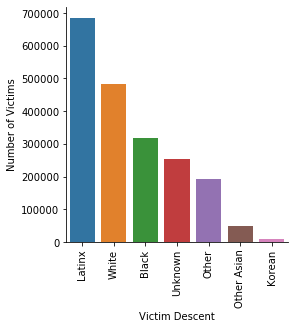

In [11]:
# Plotting  a countplot of Victim Descent
g = sns.catplot(x="Victim Descent", 
                data=clean_df, 
                kind="count",
                height=4, orient="h",
                order=clean_df['Victim Descent'].value_counts()[:7].index)

#setting x tick labels
g.set_xticklabels(['Latinx','White','Black','Unknown', 'Other', 'Other Asian','Korean'], rotation= 'vertical')

#setting y label
g.set_ylabels('Number of Victims')
g.set_titles('Distribution of victims by Descent');

In [12]:
# Proportion of victims sorted in descenting order for the 
clean_df['Victim Descent'].value_counts(normalize= True)[:10]

H    0.343869
W    0.242334
B    0.159008
X    0.127551
O    0.096124
A    0.024052
K    0.004366
F    0.001183
C    0.000443
I    0.000437
Name: Victim Descent, dtype: float64

For all the crimes reported between 2010 and June of 2019, at 34%, victims of *Latinx* descent account for the highest number of victims of crimes in that period. White victims account for 24% and Black victims account for 16% of all crime victims in that period.

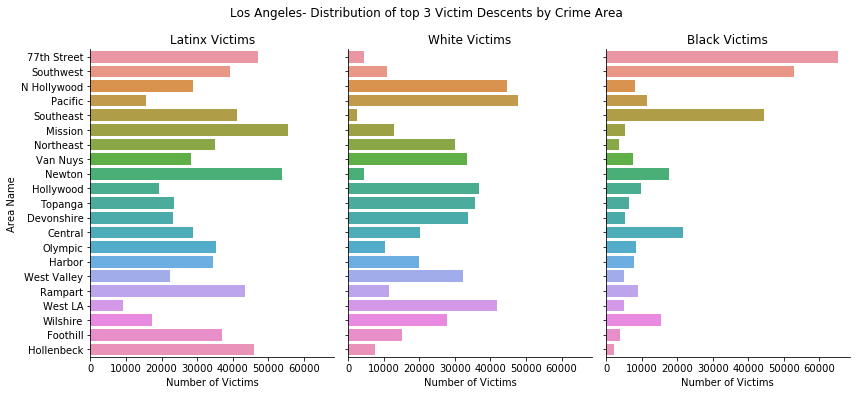

In [13]:
# Plotting a categorical estimate plot of Crime area by Descent
g = sns.catplot(y="Area Name", col="Victim Descent",
                col_order= clean_df['Victim Descent'].value_counts()[:3].index
                ,data=clean_df, kind="count",height=5, aspect=.8,
               order=clean_df['Area Name'].value_counts().index)

# Setting label an title for first facet
g.axes[0,0].set_xlabel('Number of Victims')
g.axes[0,0].set_title('Latinx Victims')

# Setting label an title for second facet
g.axes[0,1].set_xlabel('Number of Victims')
g.axes[0,1].set_title('White Victims')

# Setting label an title for third facet
g.axes[0,2].set_xlabel('Number of Victims')
g.axes[0,2].set_title('Black Victims')

#setting figure title for facetgrid plot
g.fig.suptitle('Los Angeles- Distribution of top 3 Victim Descents by Crime Area ', y = 1.05);

Looking at the top 3 vulnerable demographics in LA, Black and Latinx communities has most suffered in the highest crime occuring areas of 77th Street and Southeast. This could also be that there are lesser White people living in these two areas. White victims are highest in the North Hollywood, Pacific areas. Again, this could be because these areas have higher white population. Similarly, areas such as Mission, Newton, Rampart, Foothill and Hollenbeck have a higher number of Latinx victims than the other descents.

#### How much has crime fluctuated in the last 8 years?
To explore data on this query we must first convert the data to where the columns hold annual data and the rows hold monthly data

In [14]:
# Grouping data by date in index
crime_volume = pd.DataFrame(clean_df.groupby(clean_df.index.date).size(), 
                            columns=['crime_count']).reset_index()

# pulling out date from index to convert to datetime object
crime_volume.rename(columns = {'index':'Date'}, inplace = True)

# Converting Date column to datetime object
crime_volume['Date']= pd.to_datetime(crime_volume['Date'], format='%Y-%m-%d')

#setting datetime object as index
crime_volume.set_index('Date', inplace=True)


# Resample monthly average crime from datetime index
monthly_crime=round(crime_volume.resample('MS').mean(),2)

# uncomment code to preview data
# monthly_crime.head() 

In [15]:
# Grouping data annually
year_groups= monthly_crime.groupby(pd.Grouper(freq='A'))

# Create a new DataFrame and store yearly values in columns 
annual_crime = pd.DataFrame()

#looping throup the year_unemp groupby object as a tuple
for date,group in year_groups:
    year = date.year          #pulling the year from datetime object
    if year == 2019:          # removing year for incomplete data
        break
    series = group.values.ravel()  # flattening the array
    annual_crime[year] = series
    
# uncomment code to preview data
# annual_crime.head() 

**Now we investigate the query of crime fluctuation from year to year in data with a boxplot**

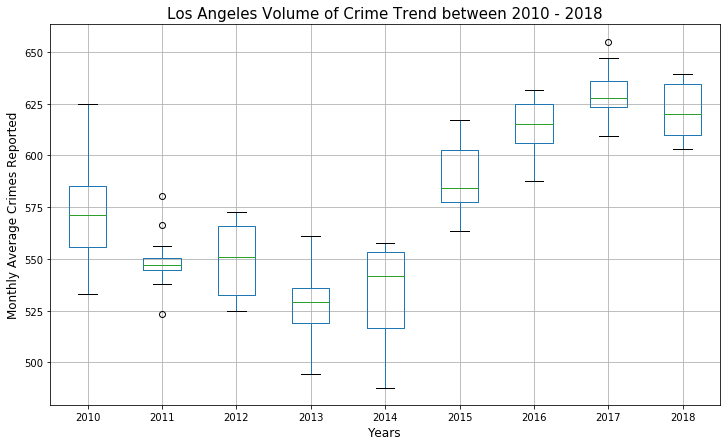

In [16]:
# Generate a box and whiskers plot for last 10 years
annual_crime.boxplot(figsize=(12,7))

#Setting figure title
plt.title('Los Angeles Volume of Crime Trend between 2010 - 2018', size = 15)

#Setting x and y label
plt.xlabel('Years', size=12)
plt.ylabel('Monthly Average Crimes Reported', size = 12)

plt.show();

The average monthly crime in the period between 2010 and 2018 ranges between 530 crimes per month to 630 crimes per months. We can also see that 2017 saw the highest average number of crimes reported, while 2013 saw the lowest average number of crimes reported in LA. 

**EDA - Autocorrelation**
We will look at the Autocorrelation function (ACF) plot or correlogram and the Partial Autocorrelation Function (PACF) plots to get get a sense of which lags are significant.

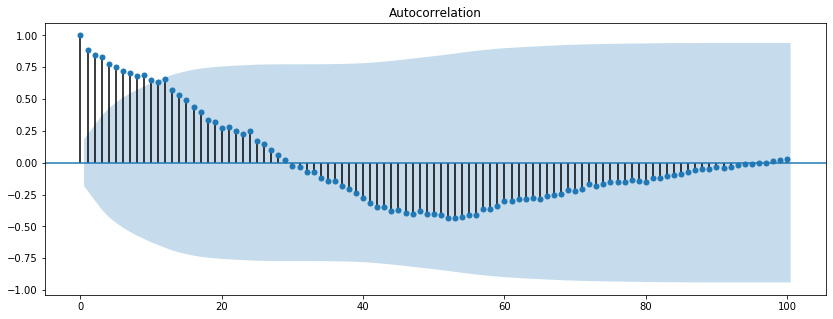

In [17]:
rcParams['figure.figsize'] = 14, 5

plot_acf(monthly_crime, lags=100, alpha=0.05);

From the ACF plot we understand that at a 95% confidence (shown by the shaded area), only the first few lags or up to 9 lags have a significant correlation, i.e, that the series is strongly correlated only for the first couple of lags and decays after that. This could be evidence that the series is random walk
We also see that there is presence of both trend and seasonality in the data.

>"When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase. When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags." -- [source](https://otexts.com/fpp2/autocorrelation.html)



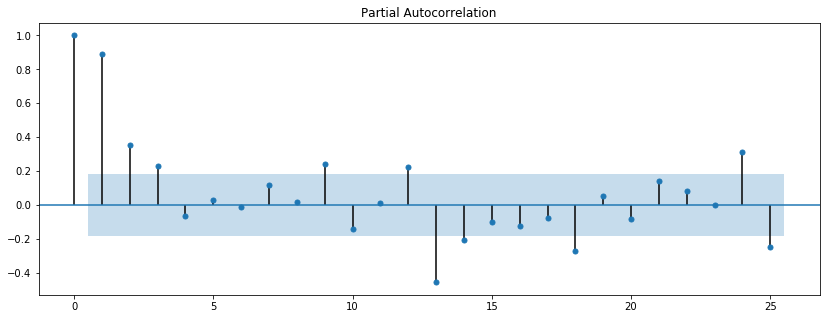

In [18]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(monthly_crime, lags=25, alpha=0.05);

From the PACF plot we see that the time series is significant for the PACF up to 3 lags after which significant lags can be seen only at around lag 12 and lag 13.

In [19]:
# monthly_crime = pd.read_pickle('data/pickled/monthly_crime.pkl')

#### EDA - Trend
Before models can be run it is important to check the data for stationary assumption. This is because in certain models, we don't want our data to be dependent on time.
One way to check on trend is to do a seasonal decomposition on the data, specially for data that fluctuates in time.

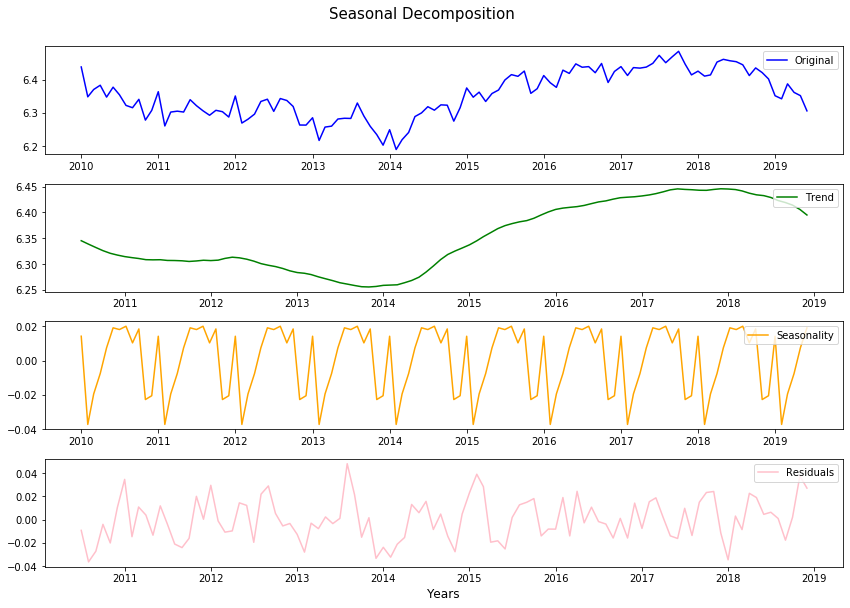

In [60]:
# Instantiating decomposition object
decomposition = seasonal_decompose(np.log(monthly_crime))

# Gather the trend, seasonality, and residuals for the monthly crime data
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.suptitle('Seasonal Decomposition', y = 1.05, size = 15)

#plotting original data in a subplot and showing legend
plt.subplot(411)
plt.plot(np.log(monthly_crime), label='Original', color='blue')
plt.legend(loc=1)

#plotting decomposed trend in a subplot and showing legend
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc=1)

#plotting decomposed seasonality in a subplot and showing legend
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='orange')
plt.legend(loc=1)

#plotting decomposed residual or noise in a subplot and showing legend
plt.subplot(414)
plt.plot(residual, label='Residuals', color='pink')
plt.legend(loc=1)
plt.xlabel('Years', size= 12)

plt.tight_layout()

The first subplot on the very top shows the plot for the original data with no decomposition. The second subplot shows a clear smooth trend pattern in the data. This is clear evidence of a non-constant mean.

The third subplot shows the decomposed seasonality pattern in the data. The last subplot shows the noise or residual component in the time series data. 

We also looked at the rolling statistics to confirm any instances of non-stationarity.

In [21]:
# calculating rolling mean and rolling standard deviation
roll_mean = monthly_crime.rolling(window=4, center=False).mean()
roll_std = monthly_crime.rolling(window=4, center=False).std()

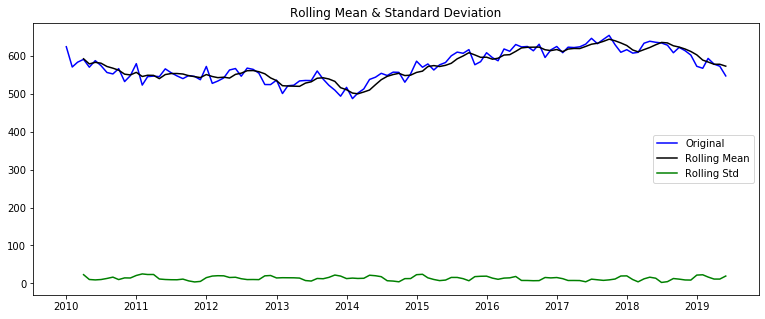

In [22]:
fig = plt.figure(figsize=(13,5))
plt.plot(monthly_crime, color='blue', label='Original')
plt.plot(roll_mean, color='black', label='Rolling Mean')
plt.plot(roll_std, color='green', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the figures above we can see that the data violates the stationarity assumption of constant mean, constant variance and constant covariance. 

To tackle this, we will difference the data and check for stationarity. Multiple iterations of differencing were performed and can be found in this [notebook]('draft_model.ipynb')

## Data Modeling

To model time series data, we need to achieve stationarity in the time series. Since, our data in the current state is not stationary, we first attempted differencing at different orders and checking for stationarity.

Also to compare for the best models we will use the AIC and the RMSE metrics. When modeling time series data and making forecasts we want to minimize the errors in our predictions. The lowest AIC and RMSE scores will give us our best model


#### Differencing

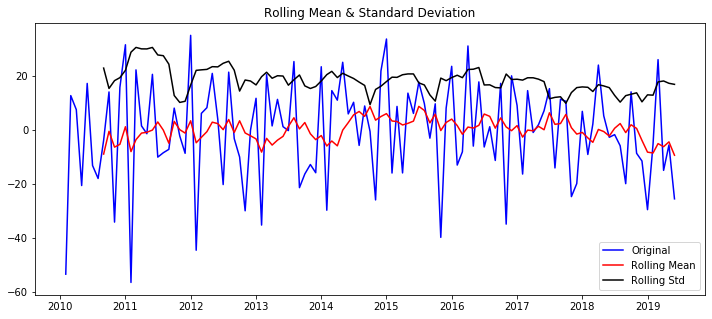

Results of Dickey-Fuller Test: 

Test Statistic                  -1.675144
p-value                          0.443962
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [23]:
#Differencing at 1 period 
crime_diff1 = monthly_crime.diff(periods=1)

#dropping any Nan values
crime_diff1.dropna(inplace=True)

#running stationarity check
modules.stationarity_check(crime_diff1)

Although the visuals show somewhat stationarity, according to the Dickey Fuller test the one period differenced data fails the stationarity test. Based on the p-value statistic, it is larger than our p-critical value of 0.05 at a 95% confidence. We fail to reject our null hypothesis of Non-Stationarity and state that there is evidence suggesting the 1 period differenced data is not stationary.

Checking at another level of differencing.

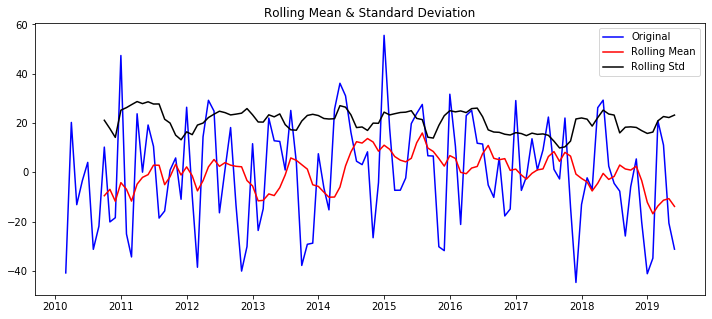

Results of Dickey-Fuller Test: 

Test Statistic                  -1.638235
p-value                          0.463183
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [24]:
#Differencing at 2nd order 
crime_diff2 = monthly_crime.diff(periods=2)

#dropping any Nan values
crime_diff2.dropna(inplace=True)

#running stationarity check 
modules.stationarity_check(crime_diff2)

At a second period differencing the data is still not stationary. We can also try differencing with the rolling mean

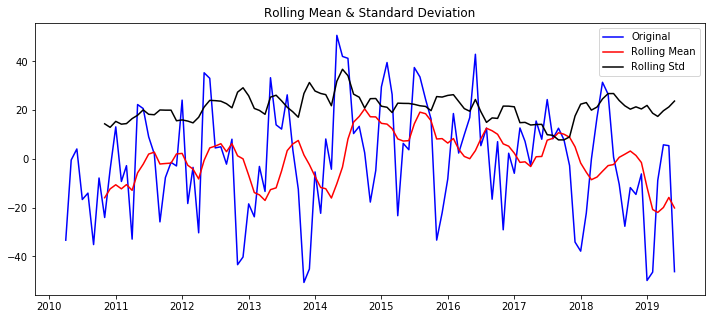

Results of Dickey-Fuller Test: 

Test Statistic                  -1.748361
p-value                          0.406383
#Lags Used                       9.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [25]:
#Differencing at 3rd order 
crime_diff3 = monthly_crime.diff(periods=3)

#dropping any Nan values
crime_diff3.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(crime_diff3)

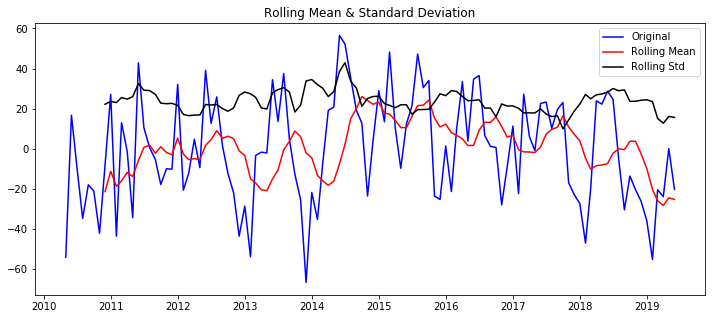

Results of Dickey-Fuller Test: 

Test Statistic                  -1.590872
p-value                          0.488177
#Lags Used                       9.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [26]:
#Differencing at 4th order 
crime_diff4 = monthly_crime.diff(periods=4)

#dropping any Nan values
crime_diff4.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(crime_diff4)

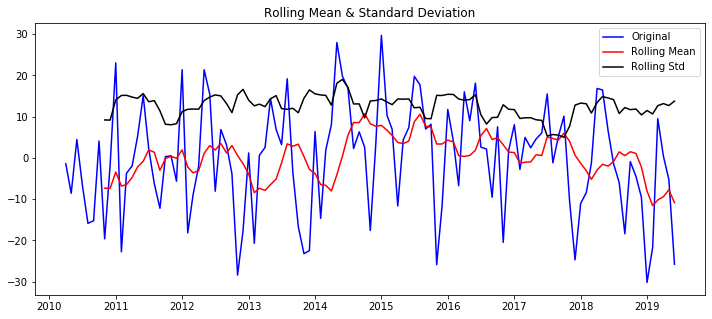

Results of Dickey-Fuller Test: 

Test Statistic                 -1.194480
p-value                         0.675966
#Lags Used                     12.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [27]:
# Subtract the moving average from the original data and previewing
# the roll_mean value comes from the Rolling Statistics calculated above
minus_roll_mean = monthly_crime - roll_mean

#removing Nans
minus_roll_mean.dropna(inplace=True)

#running stationarity check
modules.stationarity_check(minus_roll_mean)

Even after differencing with the rolling mean the data is still persistantly non- stationary. Although non-stationary, the lowest p-value achieved on the Dickey Fuller test was of 0.40, on the 3rd order differencing. We used the 3rd order differenced time series to model on.

We need to at least **make sure that the residuals or noise in the data is stationary**, to avoid any spurious regressions.
>" If there are no properties of stationarity among the residuals, then basically our results tend to produce
fake relationships in our model.'' --[source](https://blog.ms-researchhub.com/2019/07/12/discussing-the-importance-of-stationary-residuals-in-time-series-8/)

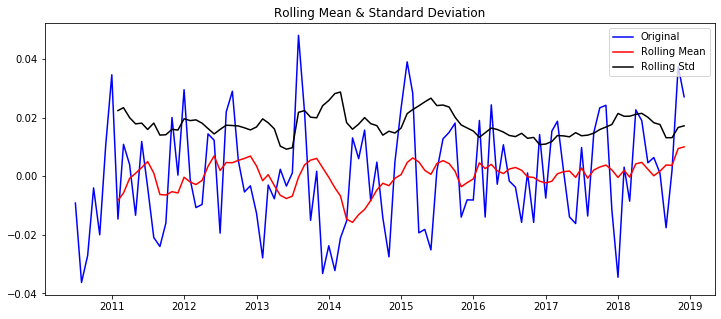

Results of Dickey-Fuller Test: 

Test Statistic                -6.996223e+00
p-value                        7.521695e-10
#Lags Used                     3.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -3.498910e+00
Critical Value (5%)           -2.891516e+00
Critical Value (10%)          -2.582760e+00
dtype: float64


In [28]:
# residual value comes from the code block on Seasonal Decomposition
crime_log_decompose = residual

# Drop missing values from residuals 
crime_log_decompose.dropna(inplace=True)

#running stationarity check
modules.stationarity_check(crime_log_decompose)

The expanded form for the dickey fuller test p- value is 0.0000000007534967. At a 95% confidence, this is clearly less than the p critical value of 0.05. Here we reject the null of non-stationarity and state that there is statistical evidence that the residuals are stationary. 

### Baseline 
**AR model on original dataset**

Splitting original data to train set and test set, to run baseline AR(1) and MA(1) models

In [63]:
Xo = monthly_crime.index
yo = monthly_crime['crime_count']

train_seto = monthly_crime.loc['2010-01-01':'2017-12-31']
test_seto = monthly_crime.loc['2018-01-01' : ]

X_traino, X_testo = train_seto.index , test_seto.index
y_traino, y_testo = train_seto['crime_count'] , test_seto['crime_count']

In [64]:
#Dictionary to collect model evaluations
mod_eval={}

# Instantiate an AR(1) model to the simulated data
mod_arma = ARMA(y_traino, order=(1,0))

# Fitting model
res_arma = mod_arma.fit()

#adding aic eval to mod eval dict
mod_eval['AR-1_aic']= res_arma.aic

# running model statistics
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   96
Model:                     ARMA(1, 0)   Log Likelihood                -418.129
Method:                       css-mle   S.D. of innovations             18.703
Date:                Mon, 07 Dec 2020   AIC                            842.259
Time:                        22:15:08   BIC                            849.952
Sample:                    01-01-2010   HQIC                           845.368
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               576.7844     15.421     37.402      0.000     546.560     607.009
ar.L1.crime_count     0.8834      0.047     18.708      0.000       0.791       0.976
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1320           +0.0000j            1.1320            0.0000
-----------------------------------------------------------------------------
"""

For a simple AR(1) model, the AIC score for the model is 842.259. The coefficients of the model are also significant at the 95% confidence level, with a p-values of less than 0.05.

In [65]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 27.53


**MA model on original dataset**

In [66]:
# Instantiate an MA(1) model to the simulated data
mod2_arma = ARMA(y_traino, order=(0,1))

# Fitting model
res_arma2 = mod2_arma.fit()

#adding aic eval to mod eval dict
mod_eval['MA-1_aic']= res_arma2.aic

# running model statistics
res_arma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   96
Model:                     ARMA(0, 1)   Log Likelihood                -454.091
Method:                       css-mle   S.D. of innovations             27.308
Date:                Mon, 07 Dec 2020   AIC                            914.181
Time:                        22:15:12   BIC                            921.874
Sample:                    01-01-2010   HQIC                           917.291
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               570.8741      4.807    118.759      0.000     561.453     580.296
ma.L1.crime_count     0.7323      0.058     12.545      0.000       0.618       0.847
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3656           +0.0000j            1.3656            0.5000
-----------------------------------------------------------------------------
"""

For a simple MA(1) model, the AIC score for the model is 914.181. The coefficients of the model are also significant at the 95% confidence level, with a p-values of less than 0.05. 

In [67]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma2.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['MA-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 42.63


In [68]:
mod_eval

{'AR-1_aic': 842.2588344593269,
 'AR-1_rmse': 27.531871559403122,
 'MA-1_aic': 914.1814057390742,
 'MA-1_rmse': 42.63420050819589}

The AR(1) model with the original data set was better than this MA(1) model based on the AIC and RMSE score.

**AR model on differenced dataset**

Using the 3rd order differenced time series. First we split the 3rd order differenced time series.

In [69]:
X = crime_diff3.index
y = crime_diff3['crime_count']

train_set = crime_diff3.loc['2010-01-01':'2017-12-31']
test_set = crime_diff3.loc['2018-01-01' : ]

X_train, X_test = train_set.index , test_set.index
y_train, y_test = train_set['crime_count'] , test_set['crime_count']

In [70]:
# Instantiate an AR(1) model to the simulated data
mod3_arma = ARMA(train_set, order=(1,0))

# Fitting model
res_arma3 = mod3_arma.fit()

#adding aic eval to mod eval dict
mod_eval['AR-1-diff_aic']= res_arma3.aic

# running model statistics
res_arma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(1, 0)   Log Likelihood                -411.588
Method:                       css-mle   S.D. of innovations             20.202
Date:                Mon, 07 Dec 2020   AIC                            829.175
Time:                        22:15:21   BIC                            836.773
Sample:                    04-01-2010   HQIC                           832.243
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7435      3.469      0.214      0.830      -6.056       7.543
ar.L1.crime_count     0.3995      0.097      4.103      0.000       0.209       0.590
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5033           +0.0000j            2.5033            0.0000
-----------------------------------------------------------------------------
"""

For a simple AR(1) model on the 3rd order differenced time series, the AIC score for the model is 829.175. The coefficients of the constant in the model is not significant while the ar.L1 coefficient is significant at the 95% confidence level, with a p-values of less than 0.05.

In [71]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma3.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 25.1


In [72]:
mod_eval

{'AR-1_aic': 842.2588344593269,
 'AR-1_rmse': 27.531871559403122,
 'MA-1_aic': 914.1814057390742,
 'MA-1_rmse': 42.63420050819589,
 'AR-1-diff_aic': 829.1753052133542,
 'AR-1-diff_rmse': 25.1035088240635}

The AR(1) model with the 3rd order differenced data set was better than our previous better model based on the AIC and RMSE score. The lowest aic score so far is 829.175 and lowest RMSE score is 25.103.

In [73]:
# Instantiate an MA(1) model to the simulated data
mod4_arma = ARMA(train_set, order=(0,1))

# Fitting model
res_arma4 = mod4_arma.fit()

#adding aic eval to mod eval dict
mod_eval['MA-1-diff_aic']= res_arma4.aic

# running model statistics
res_arma4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(0, 1)   Log Likelihood                -413.873
Method:                       css-mle   S.D. of innovations             20.715
Date:                Mon, 07 Dec 2020   AIC                            833.747
Time:                        22:15:29   BIC                            841.344
Sample:                    04-01-2010   HQIC                           836.814
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0325      2.749      0.376      0.707      -4.356       6.421
ma.L1.crime_count     0.2827      0.079      3.572      0.000       0.128       0.438
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.5367           +0.0000j            3.5367            0.5000
-----------------------------------------------------------------------------
"""

For a simple MA(1) model on the 3rd order differenced time series, the AIC score for the model is 833.747. The coefficients of the constant in the model is not significant while the ma.L1.crime_count coefficient is significant at the 95% confidence level, with a p-values of less than 0.05.

In [76]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma4.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['MA-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 25.67


In [78]:
mod_eval

{'AR-1_aic': 842.2588344593269,
 'AR-1_rmse': 27.531871559403122,
 'MA-1_aic': 914.1814057390742,
 'MA-1_rmse': 42.63420050819589,
 'AR-1-diff_aic': 829.1753052133542,
 'AR-1-diff_rmse': 25.1035088240635,
 'MA-1-diff_aic': 833.7465381347376,
 'MA-1-diff_rmse': 25.668838813367785}

So far we can see that the best model based on the AIC and the RMSE, is the AR model with a 'p' term of 1 on the 3rd order differenced time series. The lowest aic score so far is 829.175 and lowest RMSE score is 25.103.

#### ARMA model

We ran several iterations of the ARMA model with all possible combinations of p (AR term) and q (MA term) between the range of values of 1 and 5. The model iterations calculate the AIC scores and then append that and the corresponding combination to a list called `ans`. We will get the minimum AIC value collected in that list to make our ARMA model with the corresponding p and q combination.

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(1, 6)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))


In [42]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pq:
    try:
        mod = ARMA(train_set, order=comb)
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARMA (1, 1) : AIC Calculated =831.0081284341859
ARMA (1, 2) : AIC Calculated =798.366767052589
ARMA (1, 3) : AIC Calculated =799.4752795234995
ARMA (1, 4) : AIC Calculated =801.4681613013845
ARMA (1, 5) : AIC Calculated =802.9516777028177
ARMA (2, 1) : AIC Calculated =830.4402352493396
ARMA (2, 2) : AIC Calculated =799.5706027096076
ARMA (2, 3) : AIC Calculated =801.5418269170927
ARMA (2, 4) : AIC Calculated =802.9674196226695
ARMA (2, 5) : AIC Calculated =804.5502157081664
ARMA (3, 1) : AIC Calculated =826.2657196278524
ARMA (3, 2) : AIC Calculated =801.548380122053
ARMA (3, 3) : AIC Calculated =803.0376787086523
ARMA (3, 4) : AIC Calculated =803.6440482449316
ARMA (3, 5) : AIC Calculated =794.6503986100411
ARMA (4, 1) : AIC Calculated =828.2988902930613
ARMA (4, 2) : AIC Calculated =803.1740134231841
ARMA (4, 3) : AIC Calculated =804.9788803597717
ARMA (4, 4) : AIC Calculated =806.32575126094
ARMA (4, 5) : AIC Calculated =800.5497159148101
ARMA (5, 1) : AIC Calculated =826.5742618322

In [43]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq    (3, 5)
aic    794.65
Name: 14, dtype: object

From 25 combinations of p and q, we have the AIC scores for the 25 ARMA models. Of that, the best performing ARMA model is with a combination of an AR term (p) of 3 and an MA term (q) of 5, with a resulting AIC score of 794.65.

Using the pq combination we fit our model to the 3rd order differenced train data, to make predictions and calculate the model RMSE.

In [44]:
# Instantiate an AR(1) model to the simulated data
mod5_arma = ARMA(y_train, order=(3,5))

# Fitting model
res_arma5 = mod5_arma.fit()

#adding aic eval to mod eval dict
mod_eval['ARMA-3,5-diff_aic']= res_arma5.aic

# running model statistics
res_arma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            crime_count   No. Observations:                   93
Model:                     ARMA(3, 5)   Log Likelihood                -387.325
Method:                       css-mle   S.D. of innovations             14.683
Date:                Mon, 07 Dec 2020   AIC                            794.650
Time:                        18:44:03   BIC                            819.976
Sample:                    04-01-2010   HQIC                           804.876
                         - 12-01-2017                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0750      4.375      0.017      0.986      -8.499       8.649
ar.L1.crime_count    -0.7377      0.057    -12.858      0.000      -0.850      -0.625
ar.L2.crime_count     0.7424      0.098      7.614      0.000       0.551       0.934
ar.L3.crime_count     0.9952      0.056     17.745      0.000       0.885       1.105
ma.L1.crime_count     1.6685      0.021     80.189      0.000       1.628       1.709
ma.L2.crime_count     0.9380        nan        nan        nan         nan         nan
ma.L3.crime_count    -0.9906        nan        nan        nan         nan         nan
ma.L4.crime_count    -1.6692        nan        nan        nan         nan         nan
ma.L5.crime_count    -0.9467        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           -0.0000j            1.0000           -0.0000
AR.2           -0.8730           -0.4926j            1.0024           -0.4182
AR.3           -0.8730           +0.4926j            1.0024            0.4182
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4936           -0.8697j            1.0000           -0.3322
MA.3           -0.4936           +0.8697j            1.0000            0.3322
MA.4           -0.8879           -0.5175j            1.0277           -0.4160
MA.5           -0.8879           +0.5175j            1.0277            0.4160
-----------------------------------------------------------------------------
"""

The ARMA(3,5) model on the 3rd order differenced time series, the AIC score for the model is 794.65. 

The coefficients of the constant in the model is not significant, with a p value greater than 0.05.  The coefficients of the first three lags for the AR process, as well as the first lag of the MA process is significant at the 95% confidence level, with a p-values of less than 0.05. 

Coefficients of the Lags 2 to 5 of the MA process in the ARMA model may have failed to converge causing `nan` values for the standard error and the p-value statistic. 

The AIC score for an ARMA model with a pq combination of 3,1 (excluding the non-convergent MA lags) is 826.27. There may be underlying information captured from the latter lags (2-5) in the MA part, which gives the ARMA(3,5) a lower AIC score of 794.65.

In [79]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = res_arma5.predict(start='2018-01-01', end='2019-06-30',dynamic=False)

# Compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['ARMA-3,5-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 23.27


In [80]:
mod_eval

{'AR-1_aic': 842.2588344593269,
 'AR-1_rmse': 27.531871559403122,
 'MA-1_aic': 914.1814057390742,
 'MA-1_rmse': 42.63420050819589,
 'AR-1-diff_aic': 829.1753052133542,
 'AR-1-diff_rmse': 25.1035088240635,
 'MA-1-diff_aic': 833.7465381347376,
 'MA-1-diff_rmse': 25.668838813367785,
 'ARMA-3,5-diff_rmse': 23.272440830315837}

Based on our model iterations, we see from the model evaluation output above that the ARMA model with a p term of 3 and q term of 5 did the best with the lowest AIC and RMSE values.

#### SARIMAX model

Since, there is seasonality present in our data we will also run a SARIMA model that takes into account the seasonality aspect of the time series as well as the non stationarity aspect. For the SARIMA model we will train our model on the original train_seto (y_traino) and test it on the original test_seto (y_testo).

Since we do not have any exogenous variables, our SARIMAX will be a SARIMA univariate model.

Here again, we ran several iterations of the SARIMA model with all possible combinations of p (AR term), q (MA term), and d (differencing to correct for stationarity), between the range of values of 0 and 2. The iterations will also run for combinations of `pdqs`, where s stands for seasonal order, of 12. 

The model iterations calculate the AIC scores and append that and the corresponding combinations to a list called `ans`. We will get the minimum AIC value collected in that list to make our SARIMA model with the corresponding pdq and pdqs combination.

In [87]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [88]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_traino,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1477.638203430392
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1211.8823154625643
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =3547.580732152369
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =806.0747332815762
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =691.2282231474072
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2017.739502268483
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =724.5747075718821
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =594.0578020996858
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =482.6398735381185
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =813.1828267394767
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =801.8322583466926
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =667.8877754051539
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =699.7166456447969
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =692.6885931868644
ARIMA (0, 0, 0) x (

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =655.6605117195636
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =2091.1364524384026
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =587.9432023422477
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =569.4113817748381
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =1393.36337405357
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =525.0524284103476
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =502.8228409338196
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =401.81347669764114
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =577.5215748922308
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =578.6683239481707
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1928.0889079771725
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =485.2286243635974
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =483.685546842162
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =976.8133959873884
ARIMA (0, 1, 1) x (

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =579.0219481301823
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =2778.553719339086
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =482.5417803581575
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =479.74406075787124
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =1727.7571930796541
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =418.8797827050958
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =413.4115857849311
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =384.84702548857973
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =835.6522587929487
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =710.0350593673307
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =2069.8831178657883
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =700.7019599353374
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =590.504323914669
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =1775.1408101951076
ARIMA (1, 0, 0) 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1846.900104590362
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =684.9096397559427
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =571.1956839358
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =658.0772175731311
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =507.71397273456256
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =402.2658735621511
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =668.1634062091802
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =657.6399362378951
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1565.5641997871721
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =582.1579657020172
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =571.4102886505234
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =2074.448896680087
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =515.0224785651412
ARIMA (1, 1, 1) x (1, 2, 1, 12)12 :

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =1968.4824578560722
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =580.3687158161717
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =558.6843701549105
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =2510.8328855416366
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =512.5948380627224
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =492.08032220962195
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =392.8130107210411
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =570.9151738061095
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =572.7191594803944
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =2053.4669285132777
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =473.1378383782421
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =474.1428590541017
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =2432.192245575117
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =410.42405621602734
ARIMA (1, 2, 2)

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =3030.866675258565
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =470.26069331828216
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =467.81996843832127
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =2689.1336747920564
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =405.86386698882865
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =402.13373455422504
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =401.7545379795101
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =796.040688272577
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =679.5870857801763
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1125.8704276930084
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =685.9904418500262
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =571.9845360036588
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3906.5804672497625
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =658.3691892442142
ARIMA (2, 1, 1

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =2803.3616695476567
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =676.0666253863083
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =558.4854813819954
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =649.9218329165831
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =496.97615150604435
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =392.11558874596693
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =661.741359040718
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =650.376974396256
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =2821.476855544957
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =574.459862735589
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =559.7182586207415
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4043.203192263133
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =506.1321960720584
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 

In [90]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 2, 2)
pdqs    (2, 2, 2, 12)
aic           384.847
Name: 242, dtype: object

Of the 729 model iterations of various combinations of pdq and pdqs, the best performing model had an AIC score of 378.357 based on the pdq combination of (0, 0, 2) and the pdqs combination of (0, 2, 2, 12). 

Using the pdq and pdqs combinations we fit our model to the 3rd order differenced train data, to make predictions and calculate the model RMSE.

In [91]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_mod6 = sm.tsa.statespace.SARIMAX(y_traino, order=(0, 2, 2), 
                                        seasonal_order=(2, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMA_mod6.fit()

#adding aic eval to mod eval dict
mod_eval['SARIMA_aic']= output.aic

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        crime_count   No. Observations:                   96
Model:             SARIMAX(0, 2, 2)x(2, 2, 2, 12)   Log Likelihood                -185.424
Date:                            Mon, 07 Dec 2020   AIC                            384.847
Time:                                    23:15:27   BIC                            397.175
Sample:                                01-01-2010   HQIC                           389.393
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5497    102.819     -0.015      0.988    -203.071     199.972
ma.L2          0.5496     56.589      0.010      0.992    -110.363     111.462
ar.S.L12      -0.2761      0.214     -1.288      0.198      -0.696       0.144
ar.S.L24      -0.1766      0.152     -1.160      0.246      -0.475       0.122
ma.S.L12      -1.5288    209.847     -0.007      0.994    -412.822     409.764
ma.S.L24       1.0020    274.268      0.004      0.997    -536.552     538.556
sigma2       146.7511    3.9e+04      0.004      0.997   -7.63e+04    7.66e+04
===================================================================================
Ljung-Box (Q):                       37.31   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.59   Prob(JB):                         0.62
Heteroskedasticity (H):               0.66   Skew:                            -0.10
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC score for the SARIMAX(0, 2, 2)x(2, 2, 2, 12) model on the 3rd order differenced time series is 384.847. 

The parameter estimates of the model are not significant for any lags and seasonality of the AR and MA processes at the 95% confidence level, with a p-values of less than 0.05. 

In [93]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start='2018-01-01', end='2019-06-30',dynamic=False)
# start='2018-01-01', end='2019-06-30'
pred_conf = pred.conf_int()
pred_conf.head()

,lower crime_count,upper crime_count
2018-01-01,615.349616,672.614208
2018-02-01,606.407348,670.691915
2018-03-01,594.340478,665.603201
2018-04-01,593.712601,671.931392
2018-05-01,581.887943,667.045759


In [94]:
# Get the real and predicted values
Crime_forecasted = pred.predicted_mean
Crime_truth = y_testo

# Compute the mean square error
rmse = np.sqrt(((Crime_forecasted - Crime_truth)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['SARIMA_rmse']= rmse

print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 24.66


In [95]:
mod_eval

{'AR-1_aic': 842.2588344593269,
 'AR-1_rmse': 27.531871559403122,
 'MA-1_aic': 914.1814057390742,
 'MA-1_rmse': 42.63420050819589,
 'AR-1-diff_aic': 829.1753052133542,
 'AR-1-diff_rmse': 25.1035088240635,
 'MA-1-diff_aic': 833.7465381347376,
 'MA-1-diff_rmse': 25.668838813367785,
 'ARMA-3,5-diff_rmse': 23.272440830315837,
 'SARIMA_aic': 384.84702548857973,
 'SARIMA_rmse': 24.656189634965195}

We find that there is relatively small difference in the model RMSE of our previous best model ARMA-3,5 vs SARIMAX(0, 2, 2)x(2, 2, 2, 12) but the AIC for the SARIMAX(0, 2, 2)x(2, 2, 2, 12) is significantly lower, indicating a better fit model. Therfore, our final best model is the SARIMAX(0, 2, 2)x(2, 2, 2, 12).

## Final Model Analysis

Our final model is the SARIMAX(0, 2, 2)x(2, 2, 2, 12) model with an AIC of 384.85 and an RMSE of 24.66.
We will further run a plot diagnostics to check the model residuals, plot our predicted values against our observed values and also forecast and plot 24 steps from 2018 through 2019 (Our test set only has observed values from 2018 to June of 2019).

#### Plot Diagnostics

The residuals of a model are the resulting error terms from the difference between the observed value and the predicted or fitted values. By looking at the residuals we can check whether a model has satisfactorily captured the information in the data. For a good forecasting method, the residuals will pass the following assumption tests of:

1. Uncorrelated residuals. -- tells us that the model captures all information in the data
2. Residuals with zero mean.  -- tells us that the model forecasts are not biased

If the residuals fail to prove these assumptions, we cannot move forward and need to further tune the model.
To check for this in our best final SARIMAX(0, 2, 2)x(2, 2, 2, 12) model, we run a plot diagnostics below.

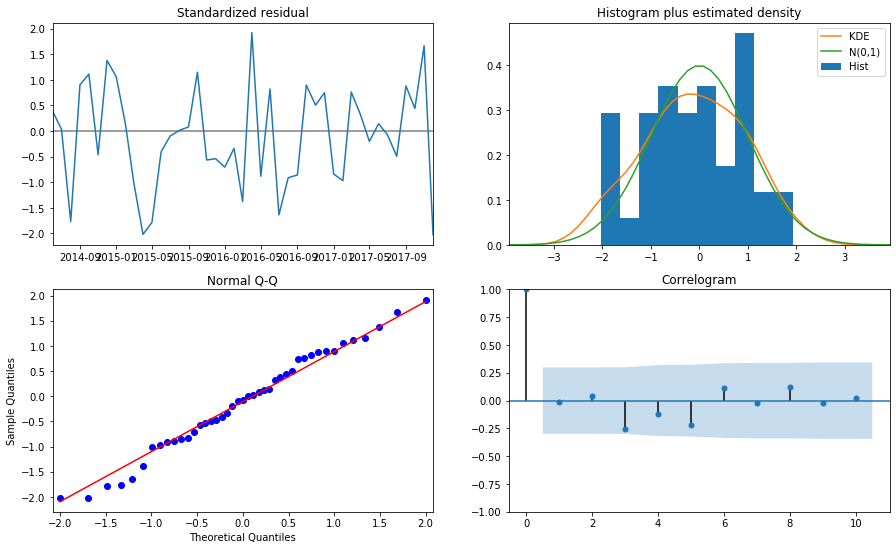

In [100]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 9))

plt.savefig('./visualizations/SARIMA Plot Diagnostics.png')
plt.show()

**Checking for these assumptions from diagnostics plots:**

* In the top right plot, we see that the orange KDE line follows closely with the N(0,1) line. This tells us that there is a good indication that the residuals are close to normally distributed i.e., **has a close to a zero mean**.


* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) weakly follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).There is fair indication that the residuals are normally distributed, i.e., **follows a close to zero mean**.


* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself, i.e., **Uncorrelated residuals**

These observations lead us to conclude that our model residuals pass both assumptions of a zero mean and no or weak correlation. Hence, there is evidence to believe that our model uses all the information available in the model to make appropriate forecasts that are unbiased.

#### Below we plot the predictions against our true observed values 

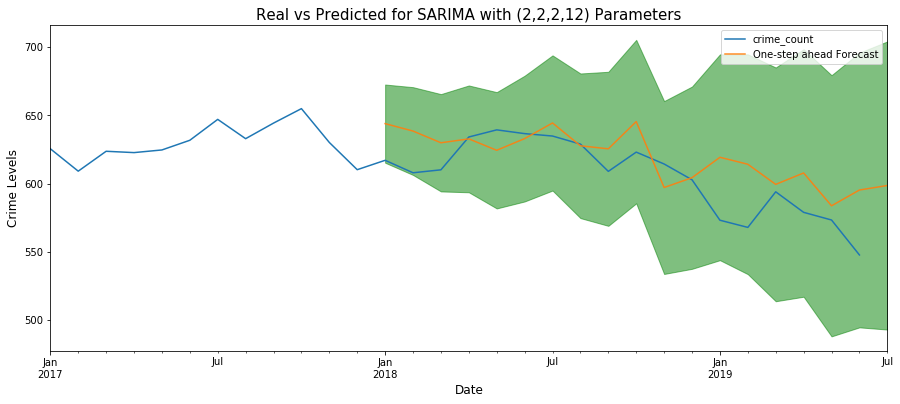

In [97]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = monthly_crime['2017-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels and title
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Crime Levels',size=12)
ax.set_title('Real vs Predicted for SARIMA with (2,2,2,12) Parameters', size=15)

plt.legend()

plt.show()

Looking at the plot above we can see that the predicted values follows the observed values very closely, also mimicking the trend and seasonality in the time series

#### Predicting forecasts and plotting against original data

In [101]:
# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

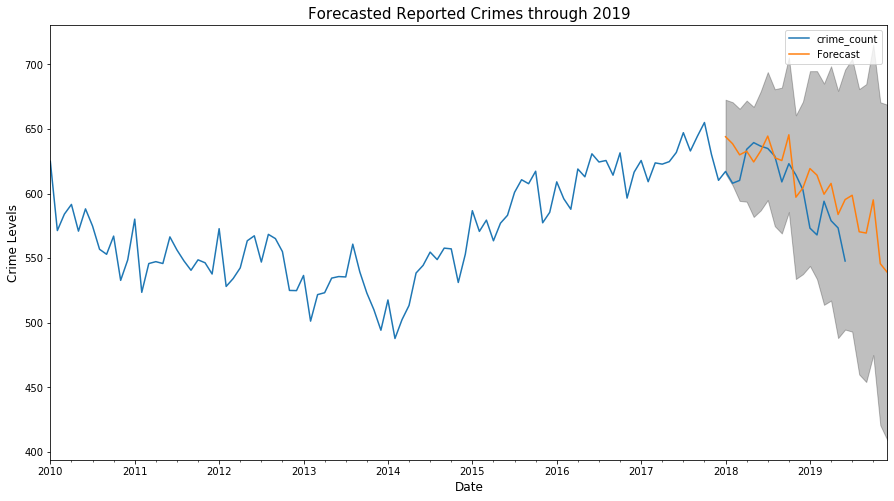

In [102]:
# Plot future predictions with confidence intervals
ax = monthly_crime.plot(label='observed', figsize=(15, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

#setting axes labels and title
ax.set_xlabel('Date', size = 12)
ax.set_ylabel('Crime Levels', size = 12)
ax.set_title('Forecasted Reported Crimes through 2019', size = 15)

plt.savefig('./visualizations/final_model_forecasts.png')
plt.legend()
plt.show()


From the Forecast plot obove we can see that, as the number of steps are increased the forecasted values stray above and away from the observed values. The confidence interval (shaded area) for the forecasts also exponentially increase with additional number of steps.

## Recommendations

Our recommendations stem primarily from our explorative data analysis. The forecasts our model predicted predicts a slight decrease in crime for 2019.

* Based on the limited forecasting power of our univariate model, we recommend compiling more historical data to build stronger predictive power

* Funding formerly allocated to the LAPD should be redistributed to social service solutions to public safety problems in the highlighted areas (77th Street, Southwest, and North Hollywood).

* Communities of color, namely Black and Latinx, makeup larger portions of the victims in these high-crime areas and should receive small business loans and other community-based incentives to help revitalize these areas.

## Next Steps

* With more time we would acquire more historical data to help make stronger predictions and forecasts further into the future.

* The addition of exogenous variables from census data would also add some complexity to our univariate model that could help us to diagnose underlying issues with crime more directly.

* Using a SARIMAX model or experimenting with Facebook Prophet would be of interest, and using incoming data to evaluate our model's forecasting performance.